In [1]:
import torch

import copy
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split

from torch import nn, optim

import torch.nn.functional as F
from arff2pandas import a2p
from dataloader import *
from utils import *
from models import *
from train_test import *
from transformer import *

cuda = torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

COLORS = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(COLORS))

rcParams['figure.figsize'] = 12, 8


1    2919
2    1767
4     194
3      96
5      24
Name: target, dtype: int64


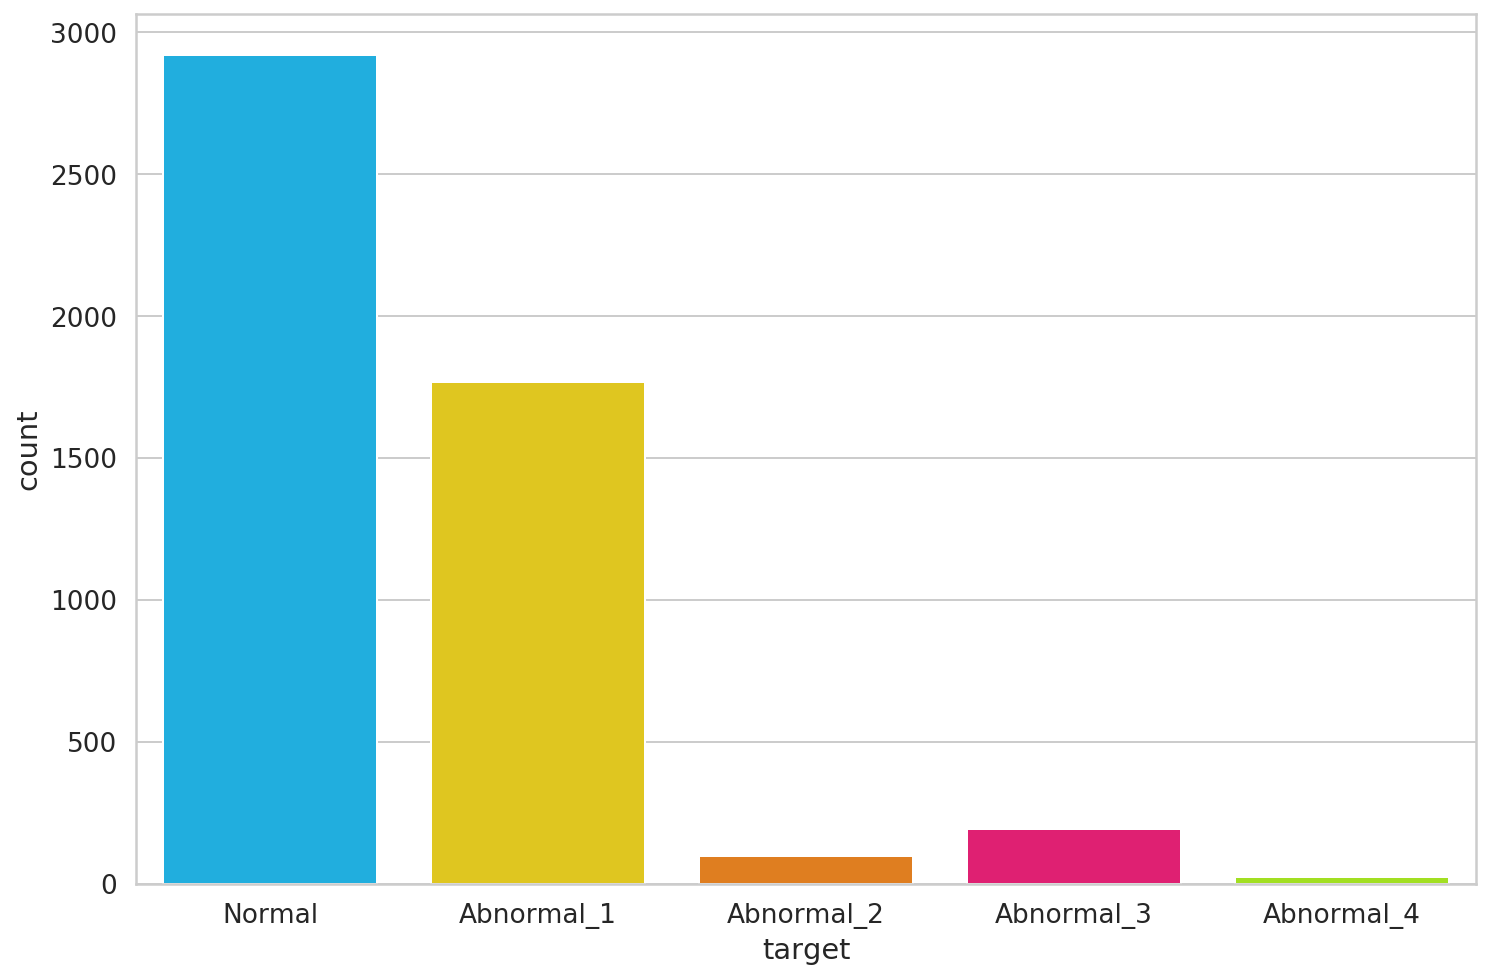

In [2]:
# load data and display its class
df = load_data()
print(df.target.value_counts())
ax = sns.countplot(df.target)
class_names = ['Normal','Abnormal_1','Abnormal_2','Abnormal_3','Abnormal_4']
ax.set_xticklabels(class_names);

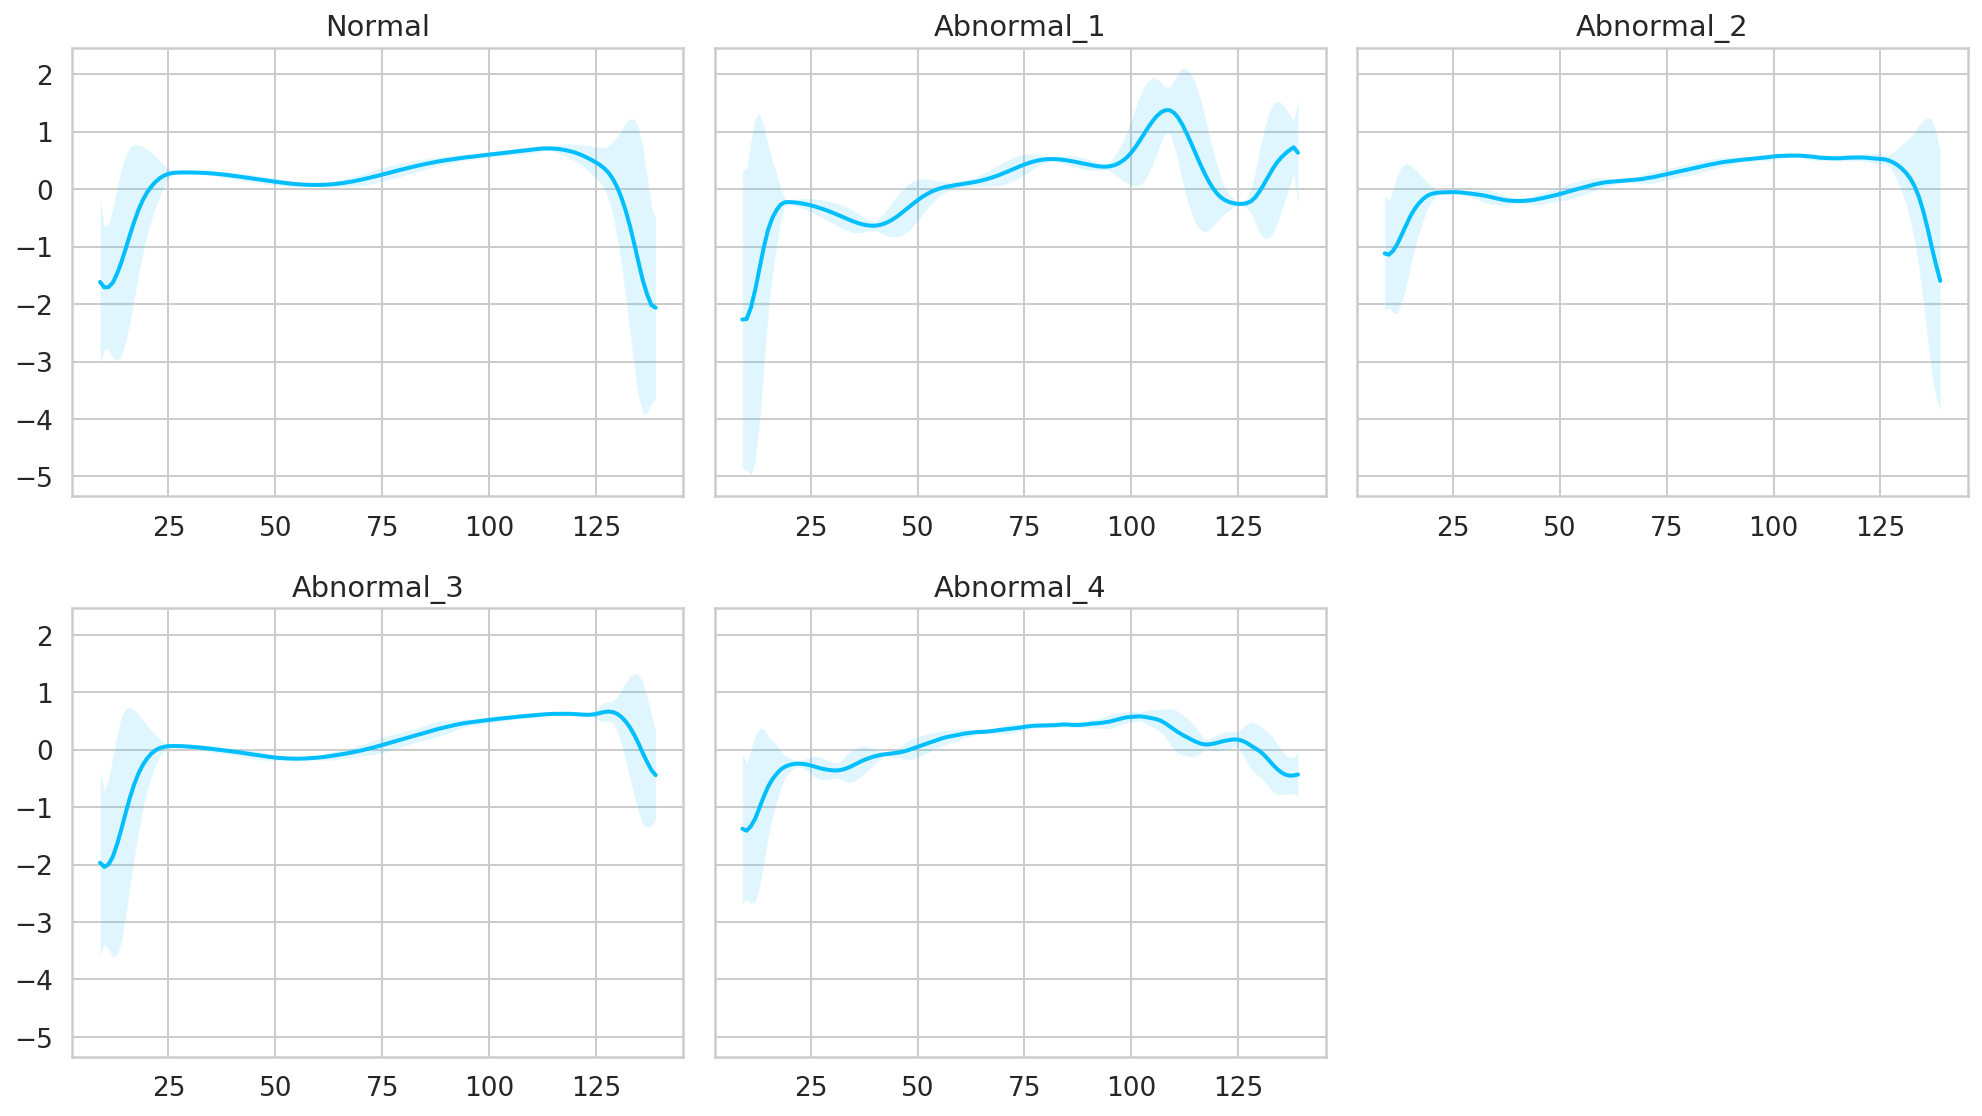

In [3]:
# Plot time series data for each class
plot_time_series_data(df, class_names)

In [4]:
# set parameters
num_workers = 4 if cuda else 0
# Preprocess data
train_df, val_df, test_df = data_preprocess(df)
n_features = train_df.shape[1]

# create dataset
train_dataset = EGG_Dataset(train_df)
val_dataset = EGG_Dataset(val_df)
test_normal_dataset = EGG_Dataset(test_df)

anomaly_df = df[df.target != str(1)].drop(labels='target', axis=1)
test_anomaly_dataset = EGG_Dataset(anomaly_df)
anomaly_dataset = test_anomaly_dataset[:len(test_normal_dataset)]

train_loader_args = dict(shuffle=True, batch_size=64, num_workers=num_workers, pin_memory=True) if cuda else dict(shuffle=True, batch_size=8)
train_loader = DataLoader(train_dataset, **train_loader_args)

val_loader_args = dict(shuffle=False, batch_size=64, num_workers=num_workers, pin_memory=True) if cuda else dict(shuffle=False, batch_size=8)
val_loader = DataLoader(val_dataset, **val_loader_args)

test_loader_args = dict(shuffle=False, batch_size=1, num_workers=num_workers, pin_memory=True)
test_normal_loader = DataLoader(test_normal_dataset, **test_loader_args)
test_anomaly_loader = DataLoader(anomaly_dataset, **test_loader_args)

In [5]:
#model = RecurrentAutoencoder(seq_len, n_features, 128)
model = Autoencoder_attention(n_features=1, hidden_dim=128, isAttended=True)
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.L1Loss(reduction='sum').to(device)

In [6]:
# train
model, history = train_attention(
    model, 
    train_loader, 
    val_loader, 
    n_epochs=150,
    optimizer = optimizer,
    criterion = criterion
)

Epoch 1: train loss 57.87042302312077 val loss 49.406559361049105
Epoch 2: train loss 49.079072595544766 val loss 43.78302001953125
Epoch 3: train loss 45.05773094383446 val loss 41.98475969587054
Epoch 4: train loss 46.764179819467905 val loss 43.09143694196428
Epoch 5: train loss 44.817670172614015 val loss 41.15827043805803
Epoch 6: train loss 41.622309834248306 val loss 34.09957484654018
Epoch 7: train loss 35.4964490735853 val loss 32.60481113978795
Epoch 8: train loss 34.65155804608319 val loss 32.44273228236607
Epoch 9: train loss 34.11175695470862 val loss 34.709074009486606
Epoch 10: train loss 32.989524123733105 val loss 30.437991071428574
Epoch 11: train loss 30.603196394636825 val loss 29.374323032924107
Epoch 12: train loss 29.889971296980576 val loss 28.34641357421875
Epoch 13: train loss 29.082506037531672 val loss 27.382897426060268
Epoch 14: train loss 28.181648411106423 val loss 26.5927969796317
Epoch 15: train loss 29.113246410472975 val loss 26.361029052734374
Epoch

Epoch 125: train loss 6.3545317118876685 val loss 6.118900124686105
Epoch 126: train loss 8.068253784179687 val loss 7.258758762904575
Epoch 127: train loss 7.873451587573902 val loss 5.928356323242188
Epoch 128: train loss 7.982470571157095 val loss 7.825159127371652
Epoch 129: train loss 6.5960609889674835 val loss 7.039810529436384
Epoch 130: train loss 8.305601295264992 val loss 10.588240792410714
Epoch 131: train loss 7.794463814400338 val loss 10.893436192103795
Epoch 132: train loss 8.121122255067569 val loss 5.7983238220214846
Epoch 133: train loss 6.000902940904772 val loss 7.103724844796317
Epoch 134: train loss 6.524680893356735 val loss 5.418494982038226
Epoch 135: train loss 7.0352474975585935 val loss 12.060459856305805
Epoch 136: train loss 8.196283561087943 val loss 8.322244960239956
Epoch 137: train loss 7.00921477446685 val loss 6.130626613071987
Epoch 138: train loss 7.2559792430980785 val loss 13.180595179966517
Epoch 139: train loss 9.03990958548881 val loss 7.5238

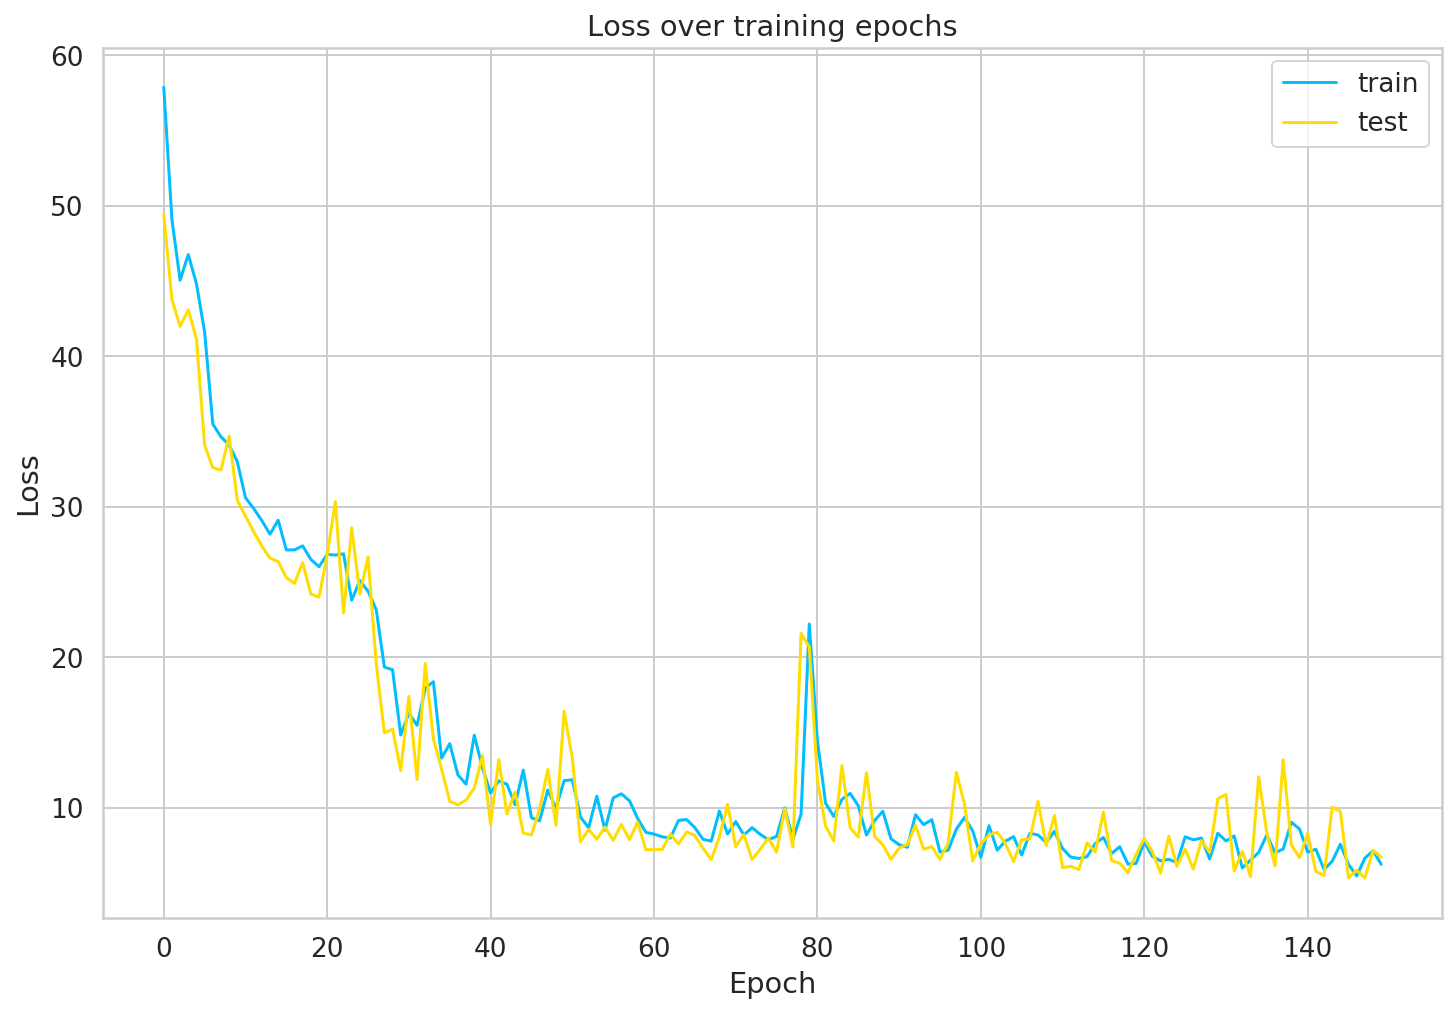

In [7]:
# plot loss
ax = plt.figure().gca()

ax.plot(history['train'])
ax.plot(history['val'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show();

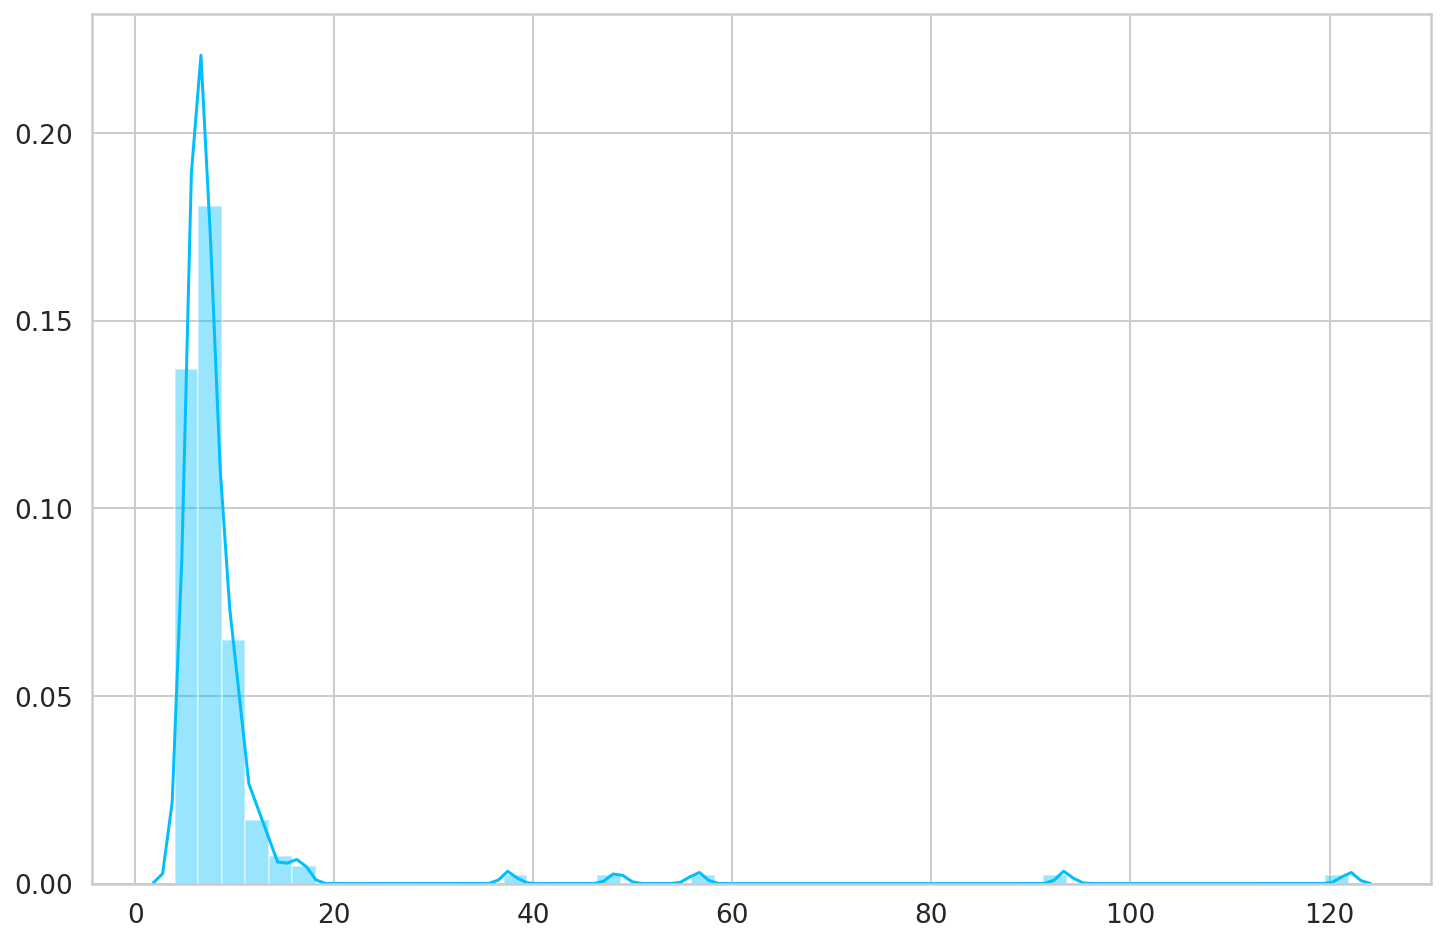

In [14]:
# Plot loss of normal data to get threshold
predictions, pred_losses = predict_attention(model, test_normal_loader, criterion)

sns.distplot(pred_losses, bins=50, kde=True);

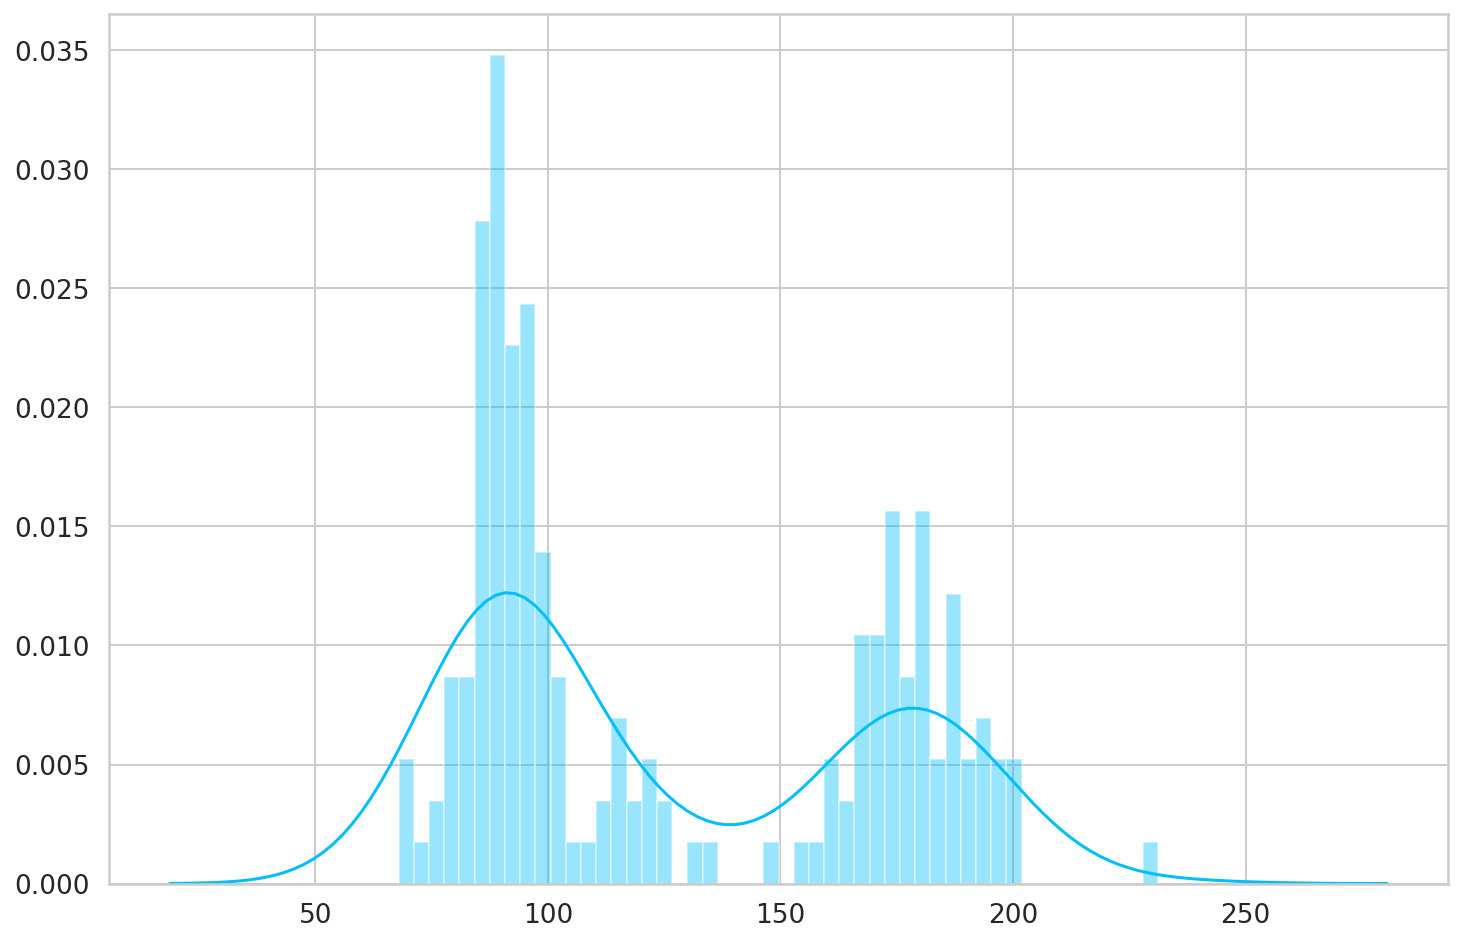

In [44]:
# Plot loss of abnormal data to get threshold
predictions, pred_losses_ab = predict_attention(model, test_anomaly_loader, criterion)

sns.distplot(pred_losses_ab, bins=50, kde=True);

In [45]:
# get threshold
threshold = 40

In [46]:
# Get TP and FP
TP = sum(l <= threshold for l in pred_losses)
FP = len(test_normal_dataset) - TP
print(f'Correct normal predictions: {TP}/{len(test_normal_dataset)}')


Correct normal predictions: 172/176


In [47]:
# Get TN and FN
TN = sum(l > threshold for l in pred_losses_ab)
FN = len(anomaly_dataset) - TN
print(f'Correct anomaly predictions: {TN}/{len(anomaly_dataset)}')


Correct anomaly predictions: 176/176


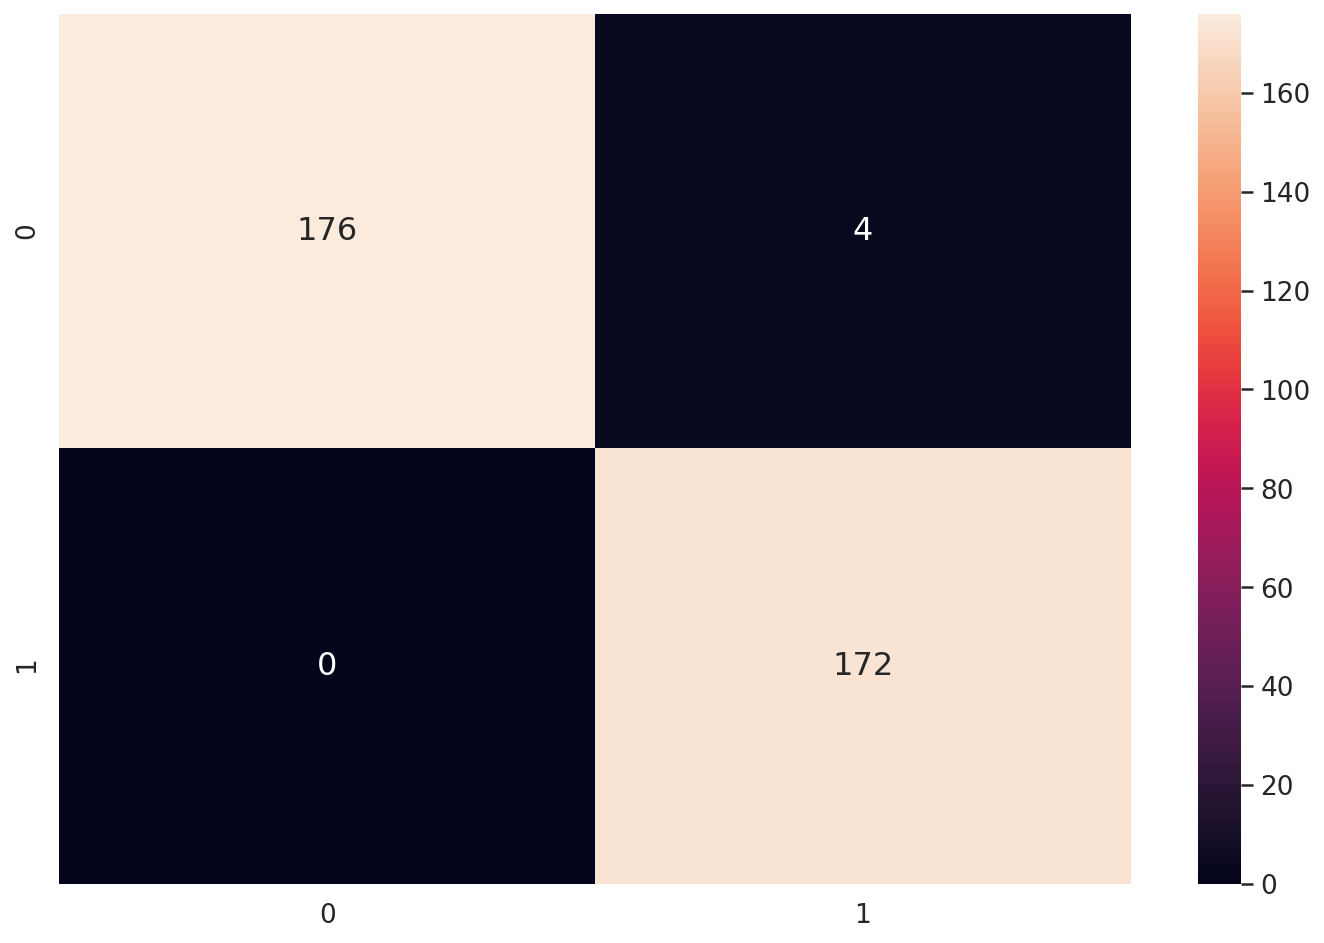

In [48]:
# Confusion matrix
conf = np.array([[TN,FP],[FN,TP]])
plt.figure()
sns.heatmap(conf,annot=True,annot_kws={"size": 16},fmt='g')